In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas
from numpy import random
import os
from google.colab.patches import cv2_imshow
import sys
import statistics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.7 MB/s 


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'/content/best.pt')

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-1 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# Defining required variables
current_frame = 0
frame = [ ]
frame_acw = [ ]
xc_yc = [ ]
xc_yc_acw = [ ]
cw_upper_row = [ ]
acw_lower_row = [ ]
frames_for_frequency = [ ]
frames_for_frequency_acw = [ ]
frame_diff_for_freq = [ ]
frame_diff_for_freq_acw = [ ]
condition = 0
fps = 1000

# Loading video file
cap = cv2.VideoCapture(r'/content/drive/MyDrive/IITK/f10_d3.MP4')

# Checkind and making folder in the desired directory
if not os.path.exists('f10_d3_Vortex_Detection'):
    os.makedirs('f10_d3_Vortex_Detection')

# Cheking whether video has been opened properly or not
while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Make detections 
    results = model(frame[400:800,:])
    
#     vortex_detect.append(results.pandas().xyxy)
#     print(np.squeeze(np.array(results.pandas().xyxy)).shape)

    # Finding the number of rows in the "results" 
    length_results = np.squeeze(np.array(results.pandas().xyxy)).shape[0]

    # preparing Frame Number Column
    frame = random.choice([current_frame], size=(np.squeeze(np.array(results.pandas().xyxy)).shape[0]))

#     print(pandas.DataFrame(np.squeeze(np.array(results.pandas().xyxy))))
#   Creating varible my_frame with the help of first frame

    # Loop lony for first frame
    if current_frame == 0:

        # "results" -> NumPy array -> squezzing to remove one dimensionality -> pandas's DataFrame
        my_frame = pandas.DataFrame(np.squeeze(np.array(results.pandas().xyxy)))
        # Joining of X_Center Column
        my_frame = my_frame.assign(X_Center= (0.5*(my_frame.loc[:,0] + my_frame.loc[:,2])))
        # Joining of Y_Center Column
        my_frame = my_frame.assign(Y_Center= (0.5*(my_frame.loc[:,1] + my_frame.loc[:,3])))
        # Joining of Frame_Number Column
        my_frame = my_frame.assign(CurentFrame= frame)
        # Sorting Row vise by taking X_Center column as a reference
        my_frame = my_frame.sort_values(by = 'X_Center')
        # Preparing seperate list of X_Center, Y_Center and Class for Post Proccessing 
        # xc_yc.append([my_frame.loc[my_frame.index[-2],'X_Center'] , my_frame.loc[my_frame.index[-2],'Y_Center'], my_frame.loc[my_frame.index[-2],5]])
        # Loop to apply different filters to organize the Data as per the requirement
        for i  in my_frame.index:
          condition = 0
          # Center line = 400, X_LHS = 1000, Y_RHS = 1200, Allowing only CW_Vortex
          if (my_frame.loc[i,'Y_Center'] < 200) and ( 750 < my_frame.loc[i,'X_Center'] < 875) and (my_frame.loc[i,5] == 1):
            condition += 1
            # Frame_Number, Class, X_Center, Y_Center
            cw_upper_row.append([my_frame.loc[i,'CurentFrame'] , my_frame.loc[i,5], my_frame.loc[i,'X_Center'],my_frame.loc[i,'Y_Center']])
          if condition == 1:
            break

        for i  in my_frame.index:
          if (my_frame.loc[i,'Y_Center'] > 200) and ( 750 < my_frame.loc[i,'X_Center'] < 875) and (my_frame.loc[i,5] == 0):
            condition += 1
            # Frame_Number, Class, X_Center, Y_Center
            acw_lower_row.append([my_frame.loc[i,'CurentFrame'] , my_frame.loc[i,5], my_frame.loc[i,'X_Center'],my_frame.loc[i,'Y_Center']])
          if condition == 1:
            break
        # print(0.5*(my_frame.loc[:,0] + my_frame.loc[:,2]))

    # Loop for all the frame except frame = 0
    else:
        # Preparing appending data
        DF = pandas.DataFrame(np.squeeze(np.array(results.pandas().xyxy)))
        DF = DF.assign(X_Center = (0.5*(DF.loc[:,0] + DF.loc[:,2])))
        DF = DF.assign(Y_Center = (0.5*(DF.loc[:,1] + DF.loc[:,3])))
        DF = DF.assign(CurentFrame= frame)
        DF = DF.sort_values(by = 'X_Center')
        # xc_yc.append([DF.loc[DF.index[-2],'X_Center'] , DF.loc[DF.index[-2],'Y_Center'], DF.loc[DF.index[-2],5]])
        for i  in DF.index:
          condition = 0
          if (DF.loc[i,'Y_Center'] < 200) and (750 < DF.loc[i,'X_Center'] < 875) and (DF.loc[i,5] == 1):
            condition += 1
            cw_upper_row.append([DF.loc[i,'CurentFrame'] , DF.loc[i,5], DF.loc[i,'X_Center'],DF.loc[i,'Y_Center']])
          if condition == 1:
            break

        for i  in DF.index:
          condition = 0
          if (DF.loc[i,'Y_Center'] > 200) and (750 < DF.loc[i,'X_Center'] < 875) and (DF.loc[i,5] == 0):
            condition += 1
            acw_lower_row.append([DF.loc[i,'CurentFrame'] , DF.loc[i,5], DF.loc[i,'X_Center'],DF.loc[i,'Y_Center']])
          if condition == 1:
            break
#         print(DF)
        # print(0.5*(DF.loc[:,0] + DF.loc[:,2]))

        # Joining DF to the my_frame variable to append all frame's data together
        my_frame = my_frame.append((DF),ignore_index = True)
        
    
#     print(results.pandas().xyxy)
#     Vortex_append = Vortex_pd.append(results.pandas().xyxy, ignore_index=True)

    # To show the frame while runnung the code
    # cv2_imshow(np.squeeze(results.render()))

    # Saving each frame in the given directory
    cv2.imwrite('./f10_d3_Vortex_Detection/frame'+ str(current_frame) + '.jpg',np.squeeze(results.render()))
    current_frame += 1
    
    # # Condition to break the run intermediately
    # if (cv2.waitKey(10) & 0xFF == ord('q')) :
    #     break
    if (cv2.waitKey(10) & 0xFF == ord('q')) or (current_frame == 100):
        break
        
# Releasing the video
cap.release()
cv2.destroyAllWindows()

# Changing the name of the Columns for sake of understanding
my_frame.columns = ['xmin', 'ymin' ,'xmax' ,'ymax','confidence', 'class', 'name', 'X-Center','Y-Center','Frame Number']

# Converting xc_yc(list) to xc_yc_array(NumPy array)
# xc_yc_array = np.array(xc_yc)
# Converting cw_upper_row(list) to cw_upper_row_array(NumPy array)
cw_upper_row_array = np.array(cw_upper_row)
acw_lower_row_array = np.array(acw_lower_row)
# Loop to find the sudden dip(fall) in the X_Center
for k in range(cw_upper_row_array.shape[0]-1):
  if (cw_upper_row_array[k,2] - cw_upper_row_array[k+1,2]) > 100 :
    frames_for_frequency.append(cw_upper_row_array[k+1,0])

for k in range(acw_lower_row_array.shape[0]-1):
  if (acw_lower_row_array[k,2] - acw_lower_row_array[k+1,2]) > 100 :
    frames_for_frequency_acw.append(acw_lower_row_array[k+1,0])
# Loop to find the Diference between to consecutive frame which cause frequency calculation
for p in range(np.array(frames_for_frequency).shape[0]-1):
  frame_diff_for_freq.append(frames_for_frequency[p+1] - frames_for_frequency[p])

for p in range(np.array(frames_for_frequency_acw).shape[0]-1):
  frame_diff_for_freq_acw.append(frames_for_frequency_acw[p+1] - frames_for_frequency_acw[p])
# Converting into pandas Series to calculate the mode
frame_diff_for_freq_pd = pandas.Series(frame_diff_for_freq)
frame_diff_for_freq_pd_acw = pandas.Series(frame_diff_for_freq_acw)
# Calculating mode and converting into NumPy array
freq_mode = np.array(frame_diff_for_freq_pd.mode())
freq_mode_acw = np.array(frame_diff_for_freq_pd_acw.mode())
# Loop to calculate final single mode out of the possibles modes
if freq_mode.shape[0] > 1:
  freq_final_frame = freq_mode.mean()
else:
  freq_final_frame = freq_mode[0]
  
if freq_mode_acw.shape[0] > 1:
  freq_final_frame_acw = freq_mode_acw.mean()
else:
  freq_final_frame_acw = freq_mode_acw[0]

frequency_cw = 1/(freq_final_frame*(1/fps))
frequency_acw = 1/(freq_final_frame_acw*(1/fps))

In [ ]:
freq_mode

array([         30,          31])

In [ ]:
frame_diff_for_freq_pd

0    30.0
1    31.0
dtype: float64

In [ ]:
my_frame

xmin        ymin         xmax        ymax confidence class  \
0      269.971191   142.99585   334.304565  204.885544   0.265763     1   
1      327.938019  170.637619   399.611603  247.844711   0.857198     0   
2      329.745819  166.889313   408.745636  241.241699   0.463637     1   
3      388.591583  128.625641   466.320496  205.370132   0.877851     1   
4      452.860107  173.827454   530.893433  249.027893   0.905077     0   
...           ...         ...          ...         ...        ...   ...   
2693   1610.41272  127.361877   1690.41626  189.761383   0.546813     1   
2694  1682.238281  181.544846  1759.713501  254.171829   0.504864     0   
2695  1752.683105  124.897713  1830.164917  188.044052   0.659434     1   
2696   1827.66394  179.227295  1900.835083  242.972443   0.430266     1   
2697  1829.174927  178.042648  1904.626831  251.740585   0.586477     0   

            name     X-Center    Y-Center  Frame Number  
0      CW_Vortex   302.137878  173.940697             0  
1     ACW_Vortex   363.774811  209.241165             0  
2      CW_Vortex   369.245728  204.065506             0  
3      CW_Vortex   427.456039  166.997887             0  
4     ACW_Vortex    491.87677  211.427673             0  
...          ...          ...         ...           ...  
2693   CW_Vortex   1650.41449   158.56163            99  
2694  ACW_Vortex  1720.975891  217.858337            99  
2695   CW_Vortex  1791.424011  156.470882            99  
2696   CW_Vortex  1864.249512  211.099869            99  
2697  ACW_Vortex  1866.900879  214.891617            99  

[2698 rows x 10 columns]

In [ ]:
print(frequency_cw,frequency_acw)

32.78688524590164 32.25806451612903


In [ ]:
print(frames_for_frequency)
print(frame_diff_for_freq)

[18.0, 48.0, 79.0]
[30.0, 31.0]


In [ ]:
frame_11 = cv2.imread(r"/content/f10_d3_Vortex_Detection/frame11.jpg",1)
frame_12 = cv2.imread(r"/content/f10_d3_Vortex_Detection/frame12.jpg",1)
frame_13 = cv2.imread(r"/content/f10_d3_Vortex_Detection/frame13.jpg",1)

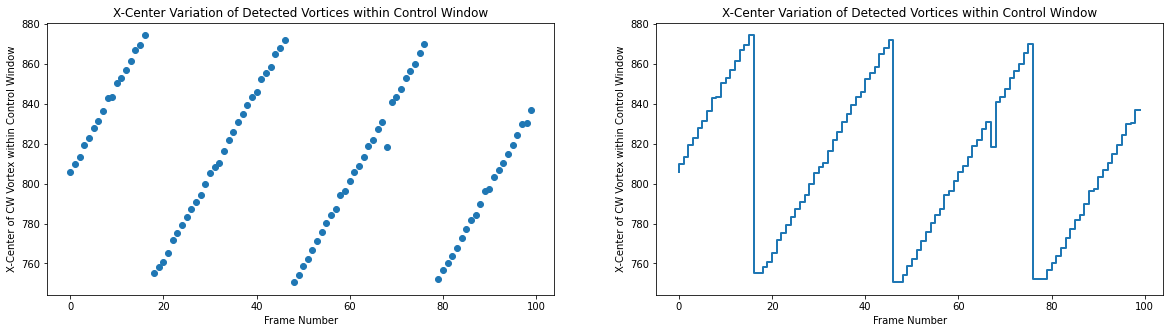

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].set_title("X-Center Variation of Detected Vortices within Control Window")
axes[0].scatter(cw_upper_row_array[:,0],cw_upper_row_array[:,2])
axes[0].set_xlabel("Frame Number")
axes[0].set_ylabel("X-Center of CW Vortex within Control Window")


axes[1].set_title("X-Center Variation of Detected Vortices within Control Window")
axes[1].set_xlabel("Frame Number")
axes[1].set_ylabel("X-Center of CW Vortex within Control Window")
axes[1].step(cw_upper_row_array[:,0],cw_upper_row_array[:,2],lw=2)

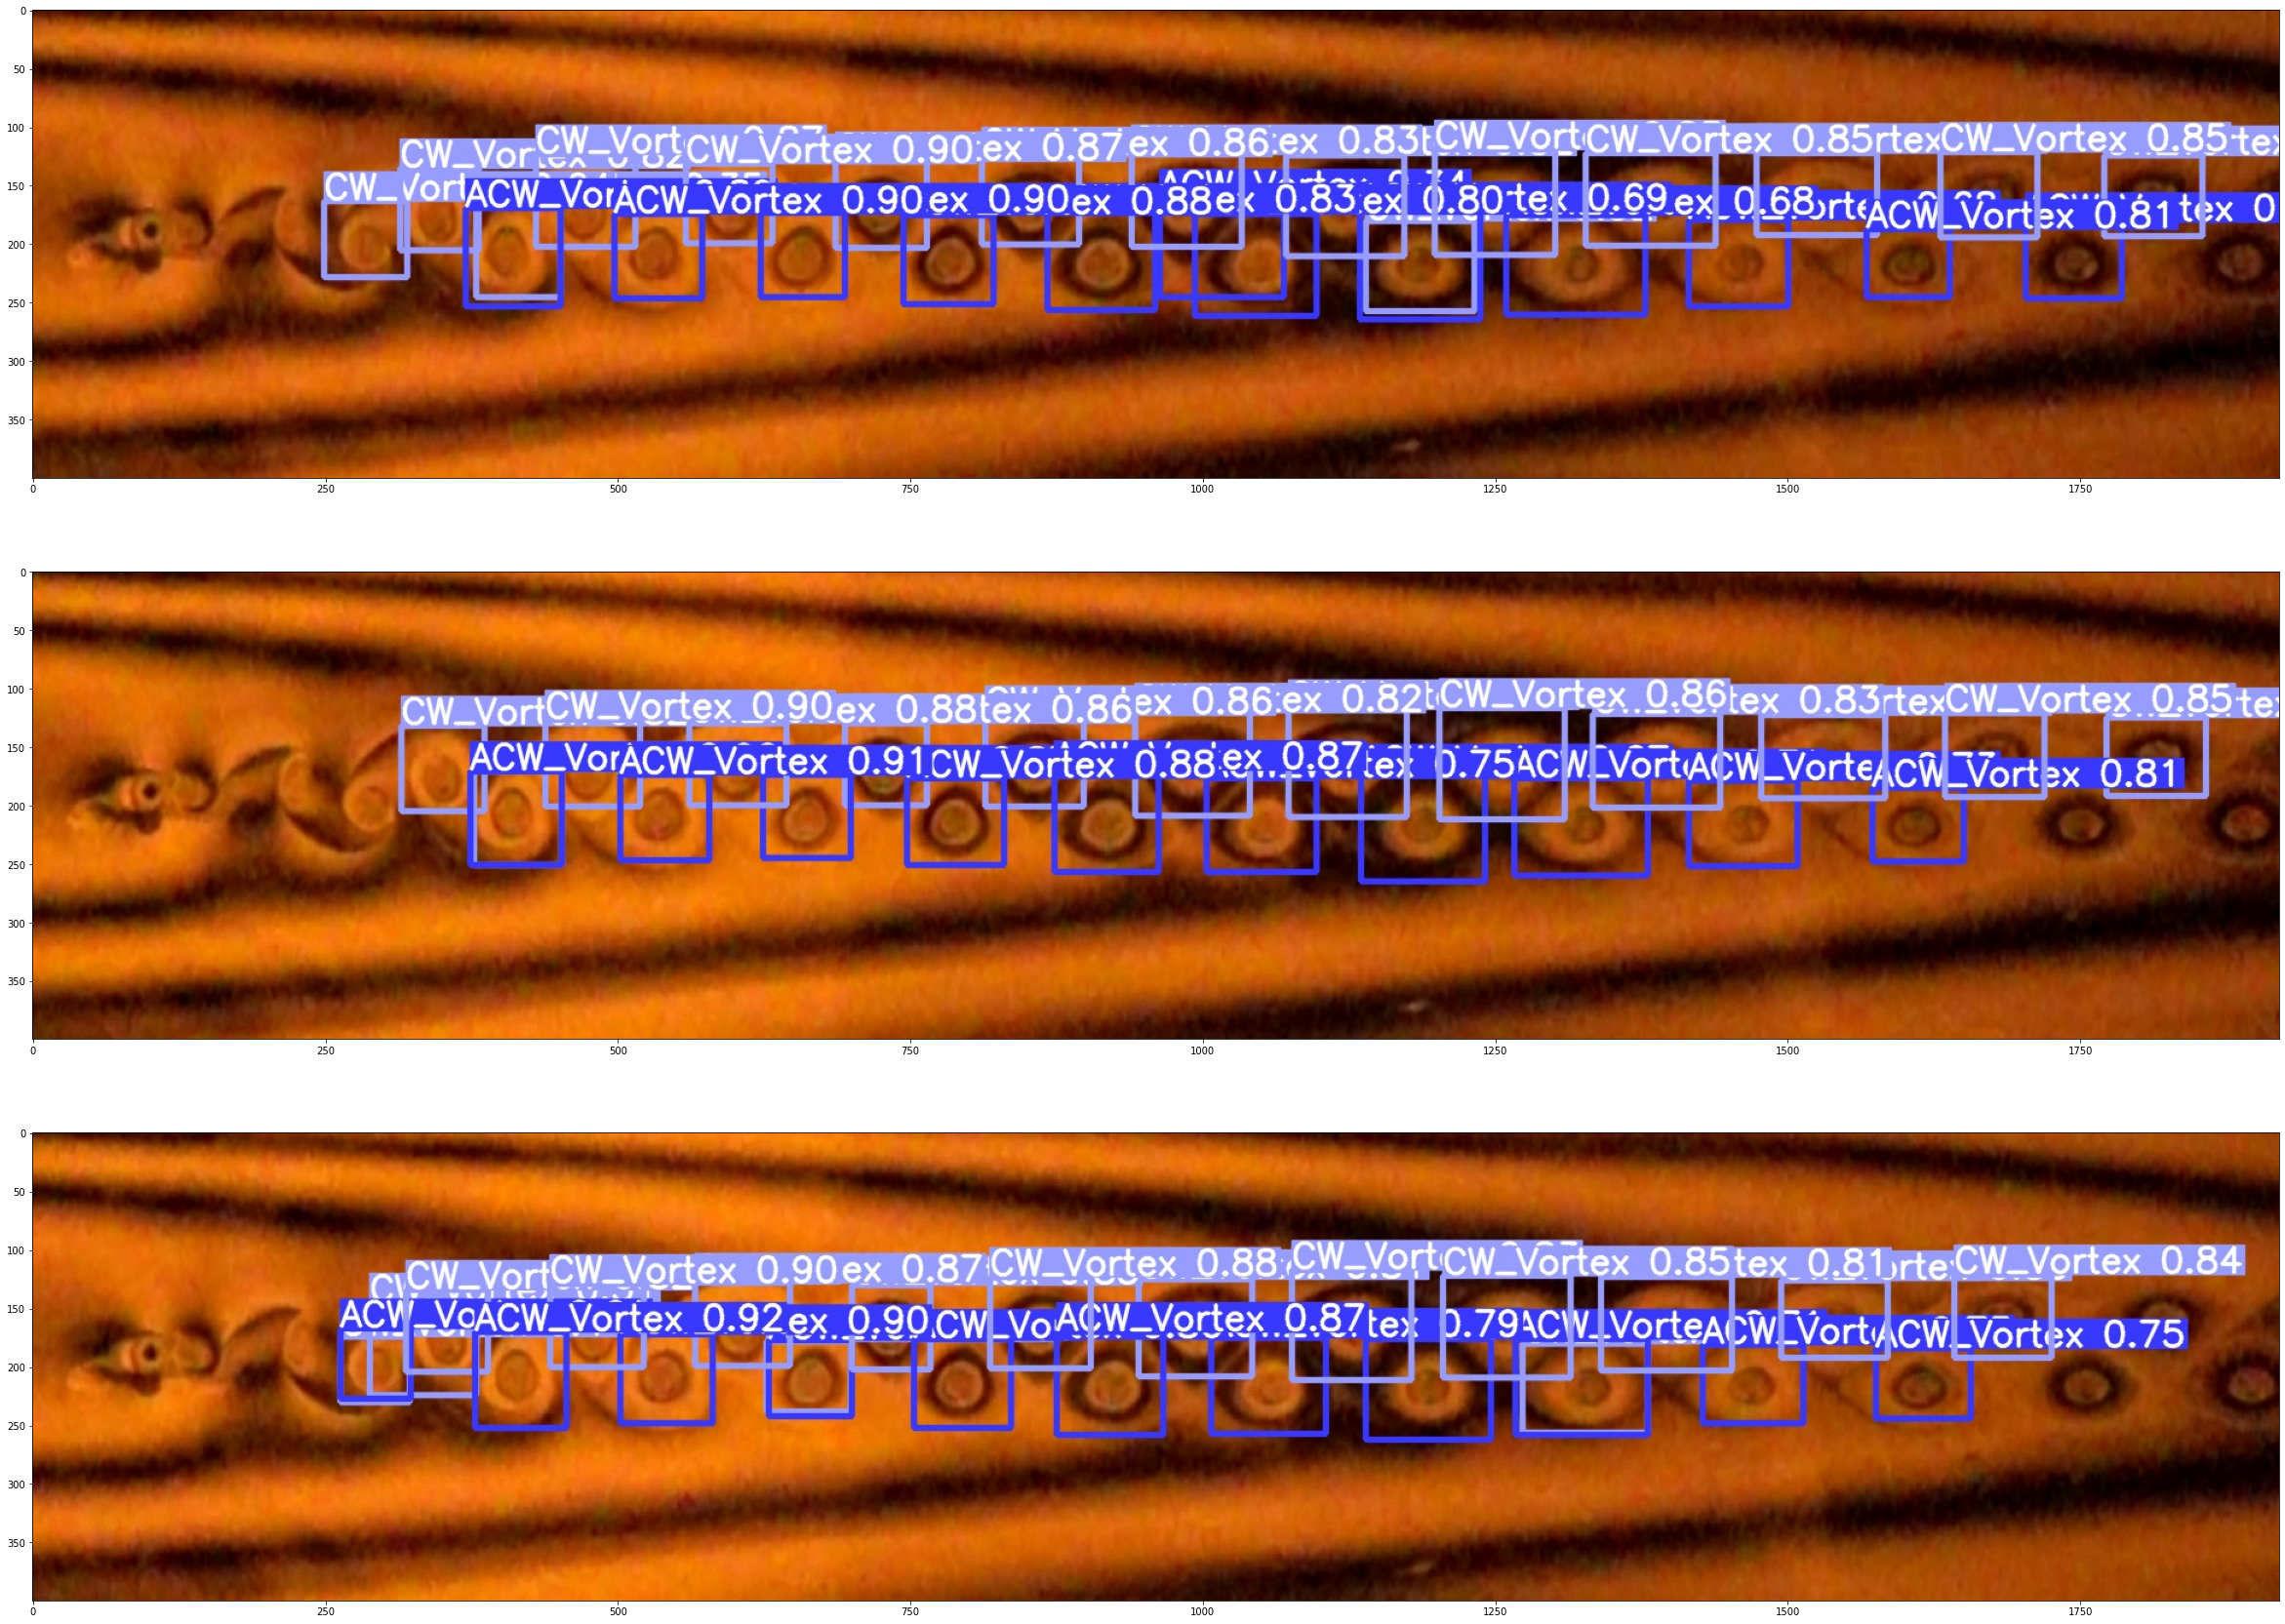

In [ ]:
%matplotlib inline 
plt.figure(figsize = ( 100 , 30 ))
plt.subplot(311), plt.imshow(frame_11[ :, : , :: - 1 ])
plt.subplot(312),plt.imshow(frame_12[ :, : , :: - 1 ])
plt.subplot(313),plt.imshow(frame_13[ :, : , :: - 1 ])
plt.show( )